### Variational Autoencoders and Generate Images in Python

In [1]:
from keras.models import Model
from keras.datasets import mnist
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras import backend as K
from keras.losses import binary_crossentropy
from numpy import reshape
import matplotlib.pyplot as plt


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [3]:
image_size = x_train.shape[1]
x_train = reshape(x_train, [-1, image_size, image_size, 1])
x_test = reshape(x_test, [-1, image_size, image_size, 1])
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [5]:
latent_dim = 8

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [6]:
input_img = Input(shape=(image_size, image_size, 1),)
h=Conv2D(16,kernel_size=3,activation='relu',padding='same',strides=2)(input_img)
enc_ouput=Conv2D(32,kernel_size=3,activation='relu',padding='same',strides=2)(h)

shape = K.int_shape(enc_ouput)

x = Flatten()(enc_ouput)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-11-18 19:40:51.922544: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-18 19:40:51.929259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 16)   160         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 32)     4640        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 1568)         0           ['conv2d_1[0][0]']               
                                                                                            

In [7]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x=Conv2DTranspose(32, kernel_size=3,activation='relu',strides=2,padding='same')(x)
x=Conv2DTranspose(16, kernel_size=3,activation='relu',strides=2,padding='same')(x)
dec_output=Conv2DTranspose(1, kernel_size=3,
activation='relu',padding='same')(x)
decoder = Model(latent_inputs, dec_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 8)]               0         
                                                                 
 dense_1 (Dense)             (None, 1568)              14112     
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       9248      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       4624      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        145 

In [8]:
outputs = decoder(encoder(input_img)[2])
vae = Model(input_img, outputs, name='vae')

reconst_loss = binary_crossentropy(K.flatten(input_img), K.flatten(outputs))
reconst_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconst_loss + kl_loss)

In [9]:
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 8),          30176       ['input_1[0][0]']                
                                 (None, 8),                                                       
                                 (None, 8)]                                                       
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    28129       ['encoder[0][2]']                
                                                                                                

In [10]:
vae.fit(x_train,epochs=20,batch_size=128,shuffle=True,validation_data=(x_test, None))

2022-11-18 20:01:08.943916: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20


2022-11-18 20:01:16.890983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 184.2630

2022-11-18 20:01:32.093275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 23s 24ms/step - loss: 184.2630 - val_loss: 159.6981
Epoch 2/20
469/469 [==============================] - 10s 21ms/step - loss: 148.4041 - val_loss: 139.8557
Epoch 3/20
469/469 [==============================] - 10s 21ms/step - loss: 140.0247 - val_loss: 136.0886
Epoch 4/20
469/469 [==============================] - 10s 20ms/step - loss: 136.7863 - val_loss: 131.5765
Epoch 5/20
469/469 [==============================] - 10s 20ms/step - loss: 133.5088 - val_loss: 128.8442
Epoch 6/20
469/469 [==============================] - 9s 18ms/step - loss: 131.1057 - val_loss: 139.2338
Epoch 7/20
469/469 [==============================] - 9s 19ms/step - loss: 129.2533 - val_loss: 128.2513
Epoch 8/20
469/469 [==============================] - 9s 19ms/step - loss: 127.7942 - val_loss: 124.2175
Epoch 9/20
469/469 [==============================] - 9s 19ms/step - loss: 125.7805 - val_loss: 122.5783
Epoch 10/20
469/469 [==============================] - 11s 23

In [11]:
z_mean, _, _ = encoder.predict(x_test)

decoded_imgs = decoder.predict(z_mean)

2022-11-18 22:07:04.501331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/313 [..............................] - ETA: 1:43

2022-11-18 22:07:11.149218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step


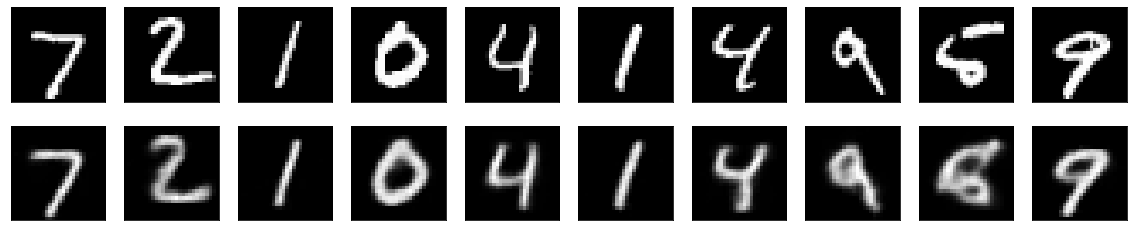

In [12]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.gray()
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i +1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()